In [1]:
%reload_ext autoreload
%autoreload 2

import pyvo  #exoplanet.eu API
import pyexoplaneteu  #alternative package to access database
import numpy as np
import os
import pandas as pd
import utils as ut
import plot_utils as pu

import matplotlib.pyplot as plt

In [2]:
data = pyexoplaneteu.get_data()
df = pd.DataFrame.from_dict(data)
df = df.loc[df.detection_type == 'Primary Transit']
df = df.sort_values(by='star_age').reset_index(drop=True)

age_lim = 0.1
df_filt = df.loc[df['star_age'] - np.abs(df['star_age_error_min']) < age_lim]	
df_filt = df_filt.sort_values(by='star_age').reset_index(drop=True)

df_filt_err = df.loc[df['star_age'] - np.abs(df['star_age_error_min']) < age_lim]	
df_filt_err = df_filt_err.sort_values(by='star_age').reset_index(drop=True)

def get_params(df):
    x = np.arange(len(df))
    y = np.array(df['star_age'])
    yerr_lower = np.abs(np.array(df['star_age_error_min']))
    yerr_upper = np.abs(np.array(df['star_age_error_max']))
    yerr = [yerr_lower, yerr_upper]

    return x, y, yerr

Access successful.


By plotting the errors in the host star age we see that everything is pretty messy:
 - the low error bar is sometimes positive and sometimes negative (we should take the abs value)
 - Some top error bars are gigantic (we take those as they are)
 - Some bottom error bars are also very big, which does not make sense as it would mean negative values for the star age (we just set those to zero and assume that the given star age is the lower bound)

NameError: name 'val' is not defined

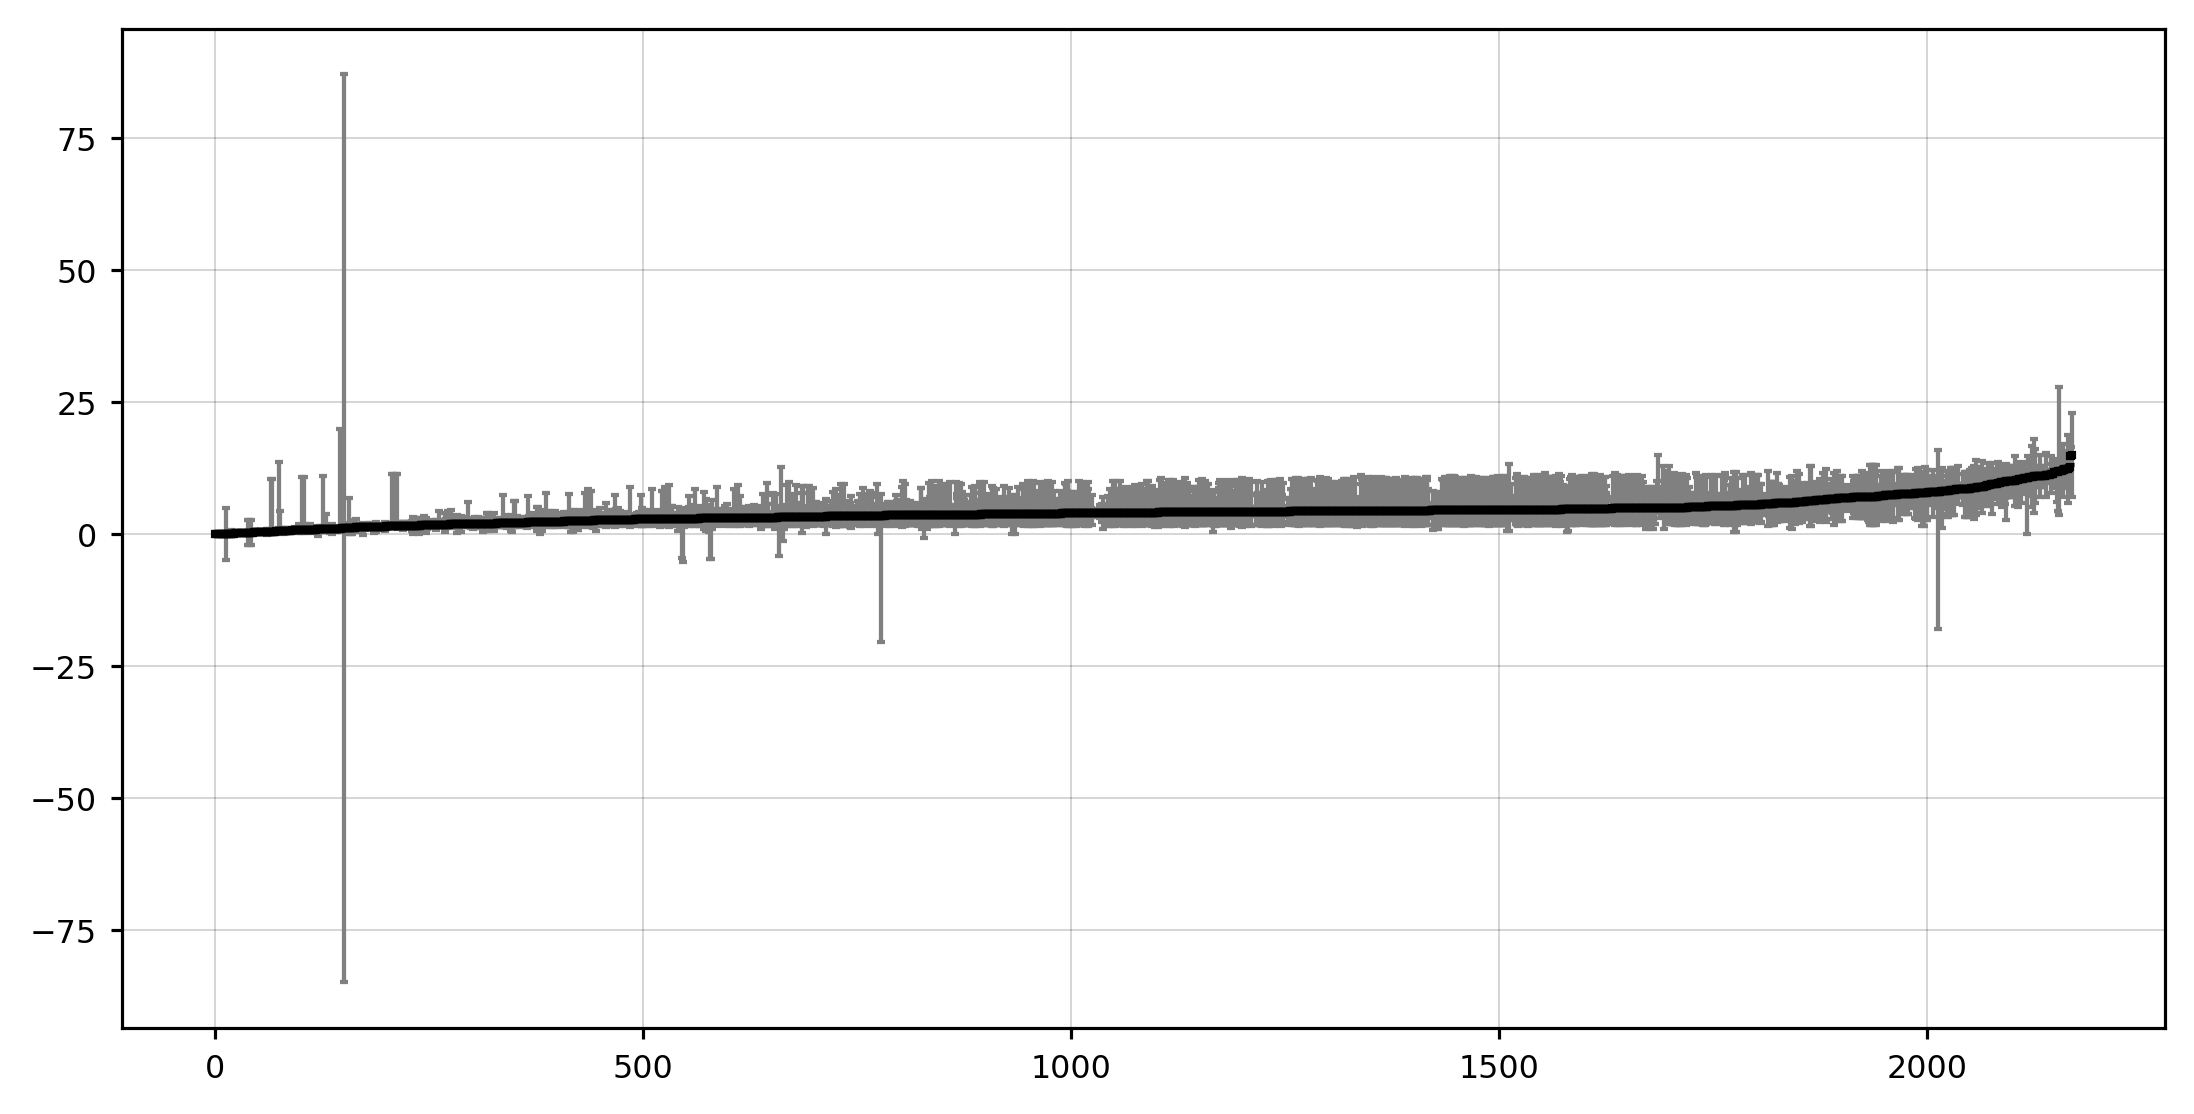

In [3]:
fig, ax, fs = pu.simp_figure(fig_w=1080*4/2, fig_h=1080, 
                             theme=None)
ms, capsize, ew = 0.2, 0.2, 0.2

ax.errorbar(*get_params(df), fmt='s', color='black', ecolor='grey', 
            capsize=capsize*fs, markersize=ms*fs, elinewidth=ew*fs, capthick=ew*fs, 
            label='Star Age')

ax.errorbar(*get_params(df), fmt='s', color='darkorange', ecolor='darkorange', 
            capsize=capsize*fs, markersize=ms*fs, elinewidth=ew*fs, capthick=ew*fs, 
            label=f'Lower Bound Star Age < {val}Gy')

# x_, y_, yerr_ = x[indices_y], y[indices_y], [yerr_lower[indices_y], yerr_upper[indices_y]]
# ax.errorbar(x_, y_, yerr=yerr_, fmt='s', color='darkred', ecolor='darkred', 
#             capsize=capsize*fs, markersize=ms*fs, elinewidth=ew*fs, capthick=ew*fs, 
#             label=f'Star Age < {val}Gy')

# Customization like title, labels, legend
ax.set_title('Star Ages with Error Bars', fontsize=fs*2)
ax.set_xlabel('Star Index', fontsize=fs*1.5)
ax.legend(loc='upper left', fontsize=fs*1.5)

ax.set_ylim(0, 15)
# ax.set_xlim(0, 10)

savefold = '../figures/age_error/'
if not os.path.exists(savefold):
    # create the folder if it does not exist
    os.makedirs(savefold)
figname = 'age_error_plot.png'
savepath = savefold + figname

fig.savefig(savepath, dpi=300, bbox_inches='tight')

plt.show()

In [52]:
text = f'From the {len(y)} stars with confirmed transits whose host star age is determined, {len(y_2)} are younger than {val} Gy considering error bars.'

print(text)

From the 2170 stars with confirmed transits whose host star age is determined, 58 are younger than 0.1 Gy considering error bars.


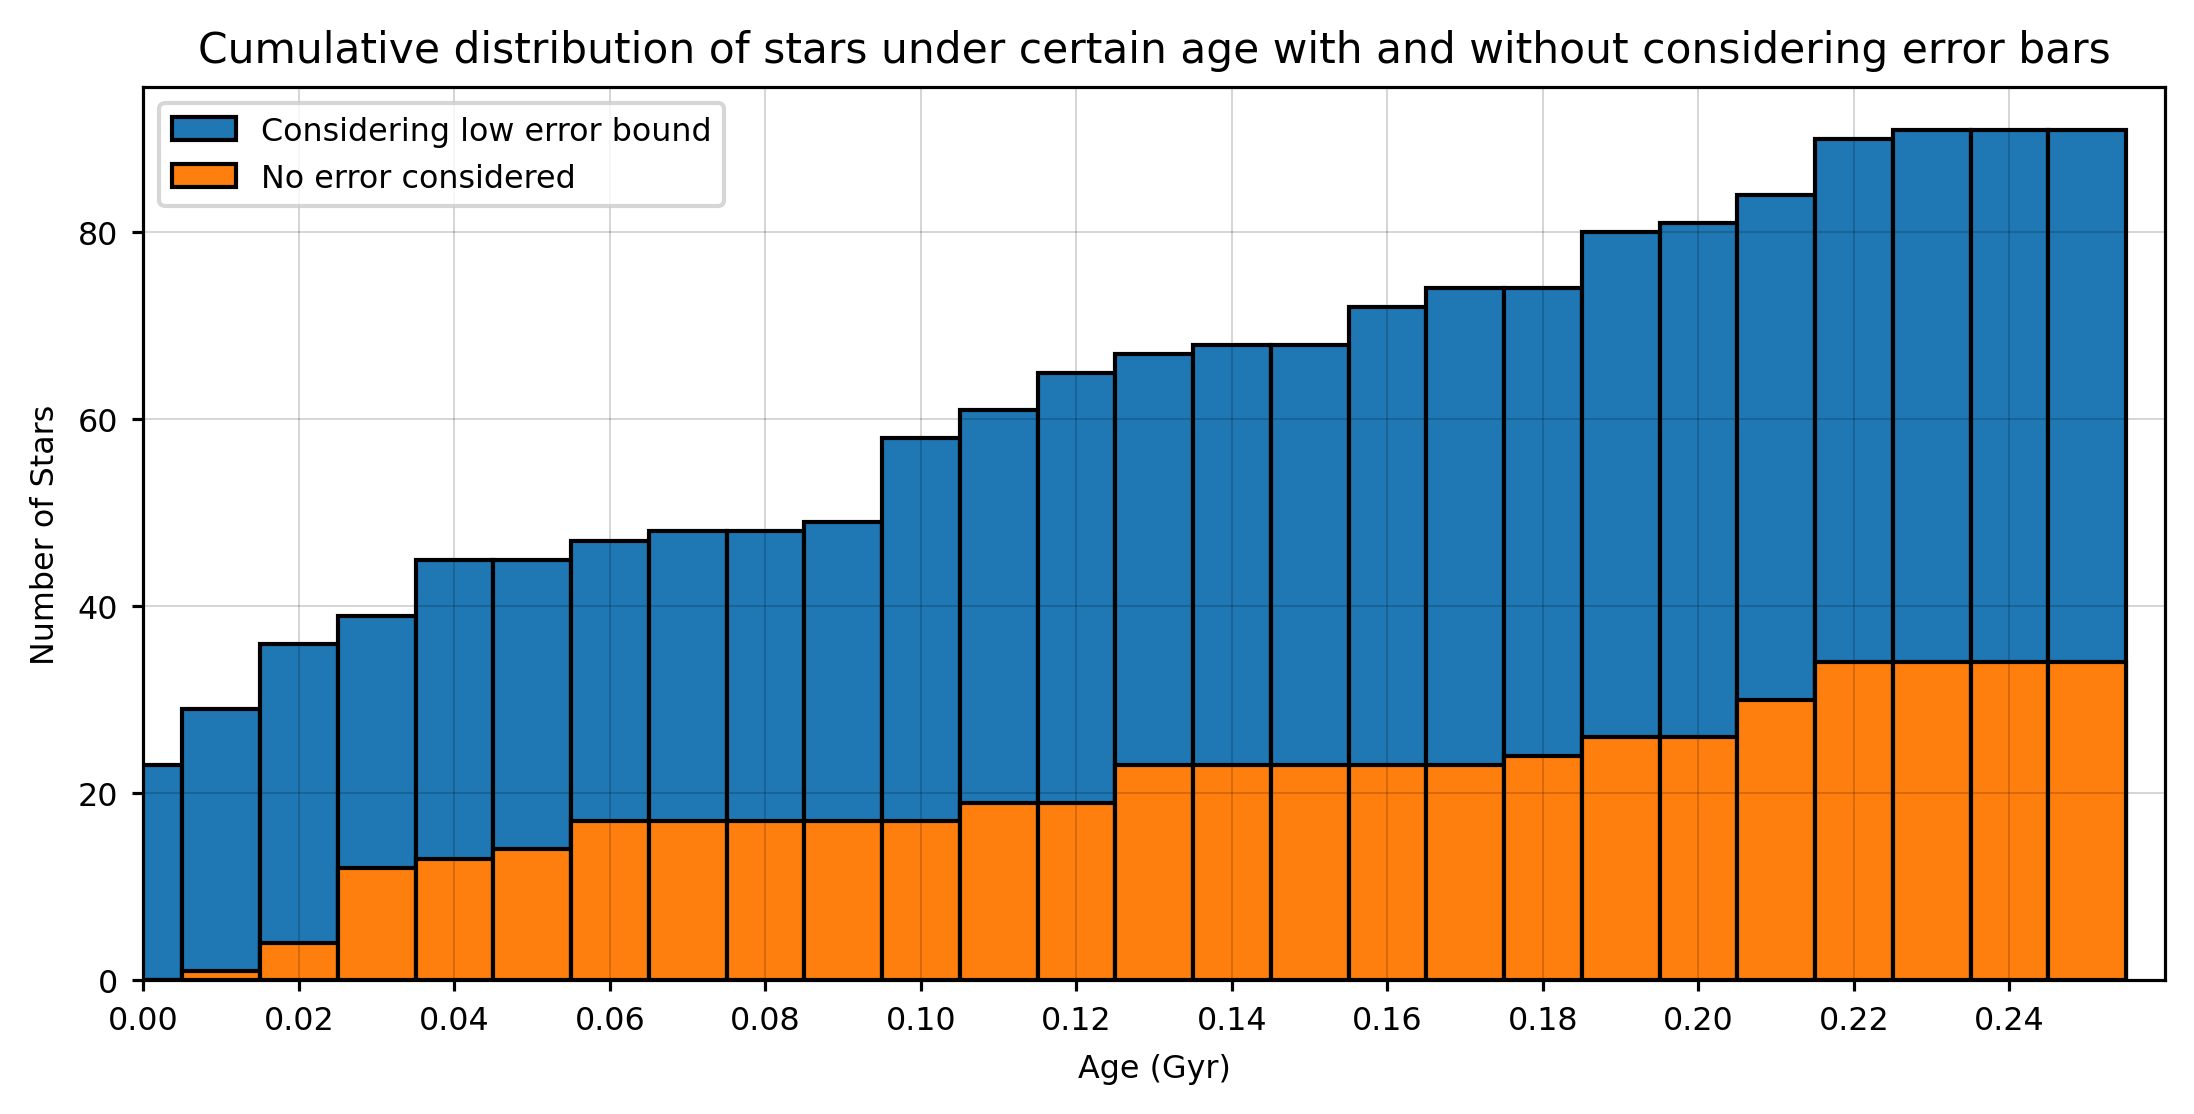

In [53]:
vals = np.linspace(0, 0.25, 26)

nums = []
nums_lowerr = []
for val in vals:
    # Indices where y < 0.2
    indices_y = np.where(y < val)[0]
    indices_y2 = np.where(y - yerr_lower < val)[0]
    nums.append(len(indices_y))
    nums_lowerr.append(len(indices_y2))

fig, ax, fs = pu.simp_figure(fig_w=1080*4/2, fig_h=1080, 
                             theme=None)

# ax.plot(vals, nums, label='No error considered', c='black')
# ax.plot(vals, nums_lowerr, label='Considering low error bound', color='darkgray')

bar_width = vals[1] - vals[0]  # or any other appropriate value for your data

ax.bar(vals, nums_lowerr, width=bar_width, 
       edgecolor='k', label='Considering low error bound')

ax.bar(vals, nums, width=bar_width, 
       edgecolor='k', label='No error considered')


# Customization like title, labels, legend
ax.set_title('Cumulative distribution of stars under certain age with and without considering error bars', fontsize=fs*2)
ax.set_ylabel('Number of Stars', fontsize=fs*1.5)
ax.set_xlabel('Age (Gyr)', fontsize=fs*1.5)
ax.legend(loc='upper left', fontsize=fs*1.5)

ax.set_xlim(0, 0.26) 

ax.set_xticks(vals[::2])

savefold = '../figures/age_error/'
if not os.path.exists(savefold):
    # create the folder if it does not exist
    os.makedirs(savefold)
figname = 'cum_age_error_plot.png'
savepath = savefold + figname

fig.savefig(savepath, dpi=300, bbox_inches='tight')

plt.show()
